In [130]:
from LOD import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy import sparse
import scipy.linalg as la
import scipy.sparse.linalg as spla
from scipy.spatial.distance import cdist
from scipy.special import kv, gamma
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator

In [131]:
# mesh parameters
H = 2**(-3)
h = 2**(-7)

Nx = int(1 / H)
Ny = Nx
refine = int(H / h)

mesh = build_triangular_mesh(Nx, Ny, refine)

coarse_nodes = mesh["coarse_nodes"]
fine_nodes   = mesh["fine_nodes"]
coarse_elems = mesh["coarse_elems"]
fine_elems   = mesh["fine_elems"]

N_H = coarse_nodes.shape[0]
N_h = fine_nodes.shape[0]

In [132]:
def matern_covariance(X, sigma=1.0, nu=1.0, kappa=0.3):
    r = cdist(X, X)
    r[r == 0.0] = 1e-12

    factor = (sigma**2) / (2**(nu - 1) * gamma(nu))
    arg = np.sqrt(2 * nu) * r / kappa

    C = factor * (arg**nu) * kv(nu, arg)
    np.fill_diagonal(C, sigma**2)
    return C

In [ ]:
class MaternGaussianField:
    def __init__(self, points, sigma=1.0, nu=1.0, kappa=0.3, mean=0.0, tol=1e-10):
        self.points = np.asarray(points, dtype=float)
        self.N = self.points.shape[0]
        self.mean = mean

        C = matern_covariance(self.points, sigma, nu, kappa)

        eigvals, eigvecs = np.linalg.eigh(C)
        eigvals = np.clip(eigvals, tol, None)

        self.A = eigvecs @ np.diag(np.sqrt(eigvals))

    def sample(self, rng=np.random.default_rng()):
        z = rng.normal(size=self.N)
        return self.mean + self.A @ z

In [134]:
field = MaternGaussianField(
        fine_nodes,
        sigma=1.0,
        nu=0.5,
        kappa=0.1,
        mean=0.0,
    )

In [135]:
def make_lognormal_kappa(
    points,                 # (N, 2)
    field,
    rng,
):
    Z = field.sample(rng)
    A = np.exp(Z)   # lognormal field

    # Scattered interpolator
    interpolator = LinearNDInterpolator(points, A)

    def kappa_func(x, y):
        x = np.atleast_1d(x)
        y = np.atleast_1d(y)
        pts = np.column_stack([x, y])
        return interpolator(pts)

    return kappa_func, A

In [136]:
rng = np.random.default_rng()

kappa, kappa_nodes = make_lognormal_kappa(
    fine_nodes,
    field,
    rng
)

In [147]:
kappa_nodes.shape

(16641,)

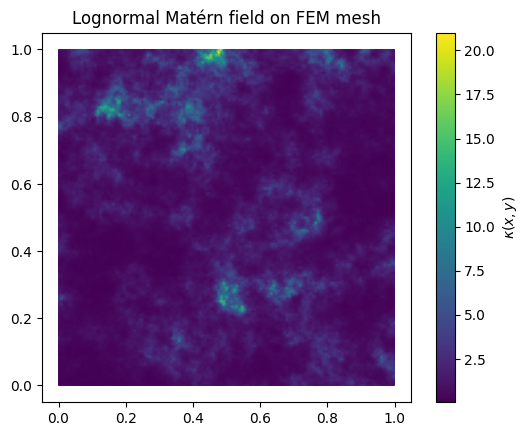

In [137]:
plt.tripcolor(
    fine_nodes[:,0],
    fine_nodes[:,1],
    kappa_nodes,
    shading="gouraud"
)
plt.colorbar(label=r"$\kappa(x,y)$")
plt.gca().set_aspect("equal")
plt.title("Lognormal Matérn field on FEM mesh")
plt.show()

In [138]:
rough_coeff = lambda x,y: kappa(x,y)

print("Assemble Stiffness Matrix...")
A_dc, M_dc, sigma = build_fine_element_matrices(mesh, rough_coeff, n_jobs=-1)

print("Assemble global...")
A_h, M_h = assemble_global_from_Adc_Mdc(A_dc, M_dc, sigma, N_h)

print("Assemble load vec...")
# load vector f ≡ 1
f_h = assemble_load_tri(
    fine_nodes, fine_elems, lambda x, y: 1.0
)

# interpolation and boundary matrices
print("Assemble interpolation matrix...")
P_h = build_P_triangular(mesh)
print("Assemble B_H")
B_H = build_B_H(coarse_nodes, Nx, Ny)

Assemble Stiffness Matrix...
Assemble global...
Assemble load vec...
Assemble interpolation matrix...
Assemble B_H


In [139]:
adjacency = build_coarse_adjacency_edge(coarse_elems)
fine_in_coarse = precompute_fine_in_coarse(mesh)

In [140]:
C_h = build_IH_quasi_interpolation(mesh)

In [141]:
k=5
Q_h = computeCorrections(mesh, k, adjacency, fine_in_coarse, A_h, B_H, C_h, rough_coeff, n_jobs=-1)

In [142]:
u_h_LOD, u_H_LOD = solveLODSystem(
    A_h, f_h, P_h, Q_h, B_H
)

In [143]:
u_h_fine = solve_fine_problem(A_h, f_h, fine_nodes)

In [145]:
np.linalg.norm(u_h_LOD - u_h_fine) / np.linalg.norm(u_h_fine)

np.float64(0.019848099441266608)

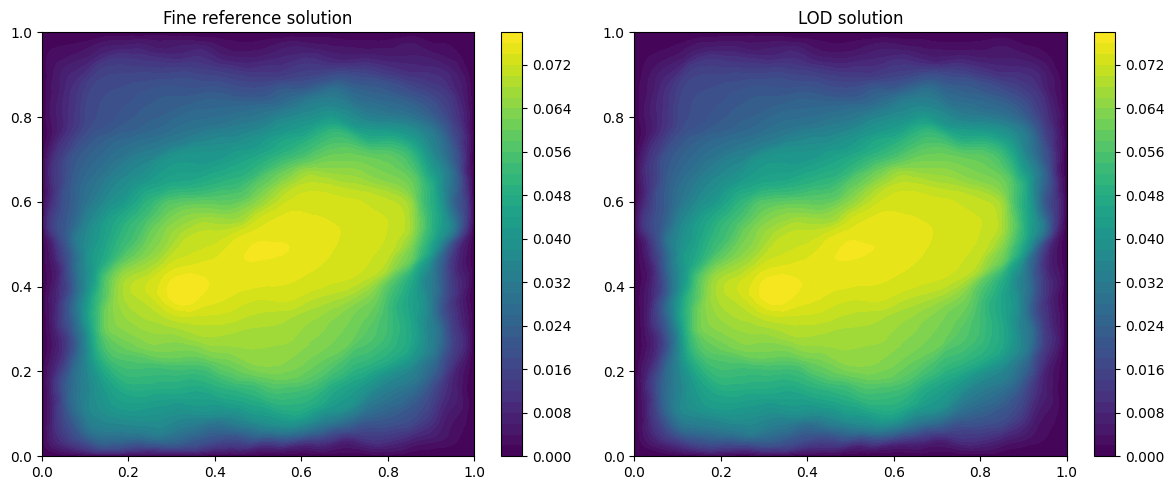

In [146]:
tri = mtri.Triangulation(
    fine_nodes[:,0],
    fine_nodes[:,1],
    fine_elems
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.tricontourf(tri, u_h_fine, levels=50)
plt.colorbar()
plt.title("Fine reference solution")

plt.subplot(1,2,2)
plt.tricontourf(tri, u_h_LOD, levels=50)
plt.colorbar()
plt.title("LOD solution")

plt.tight_layout()
plt.show()